# STAT-6289
# HW-2

### Chengyi Yang
### G 41160789

***Load and normalize CIFAR10****

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Question (a)

Let us show some of the training images, for fun.

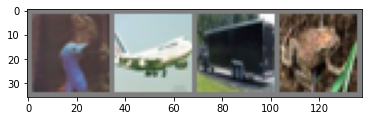

bird  plane truck frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Original CNN Model in the sample

In [4]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_1 = Net()
net_1 = net_1.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_1 = []
train_acc_1 = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net_1.to('cuda')
    net_1.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_1.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_1.eval()
    net_1.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_1(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_1.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.36418
Accuracy of the network in 1th epoch on the 10000 test images: 47 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.51574
Accuracy of the network in 2th epoch on the 10000 test images: 52 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.57242
Accuracy of the network in 3th epoch on the 10000 test images: 53 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.60776
Accuracy of the network in 4th epoch on the 10000 test images: 59 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.62852
Accuracy of the network in 5th epoch on the 10000 test images: 61 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.64882
Accuracy of the network in 6th epoch on the 10000 test images: 62 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.66514
Accuracy of the network in 7th epoch on the 10000 test images: 60 %
Accuracy of the netw

 0 hidden layer

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


net_2 = Net()
net_2 = net_2.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_2.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_2 = []
for epoch in range(n_epochs): 
    net_2.to('cuda')
    net_2.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_2.eval()
    net_2.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_2(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_2.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 42 %
Accuracy of the network in 2th epoch on the 10000 test images: 43 %
Accuracy of the network in 3th epoch on the 10000 test images: 43 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 46 %
Accuracy of the network in 6th epoch on the 10000 test images: 45 %
Accuracy of the network in 7th epoch on the 10000 test images: 46 %
Accuracy of the network in 8th epoch on the 10000 test images: 48 %
Accuracy of the network in 9th epoch on the 10000 test images: 47 %
Accuracy of the network in 10th epoch on the 10000 test images: 47 %
Finished Training


1 hidden layer

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_3 = Net()
net_3 = net_3.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_3.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_3 = []
for epoch in range(n_epochs):
    net_3.to('cuda')
    net_3.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_3.eval()
    net_3.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_3(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_3.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 42 %
Accuracy of the network in 2th epoch on the 10000 test images: 46 %
Accuracy of the network in 3th epoch on the 10000 test images: 45 %
Accuracy of the network in 4th epoch on the 10000 test images: 47 %
Accuracy of the network in 5th epoch on the 10000 test images: 47 %
Accuracy of the network in 6th epoch on the 10000 test images: 47 %
Accuracy of the network in 7th epoch on the 10000 test images: 47 %
Accuracy of the network in 8th epoch on the 10000 test images: 47 %
Accuracy of the network in 9th epoch on the 10000 test images: 47 %
Accuracy of the network in 10th epoch on the 10000 test images: 48 %
Finished Training


2 hidden layer

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x


net_4 = Net()
net_4 = net_4.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_4.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_4 = []
for epoch in range(n_epochs):  
    net_4.to('cuda')
    net_4.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_4(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_4.eval()
    net_4.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_4(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_4.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 42 %
Accuracy of the network in 2th epoch on the 10000 test images: 45 %
Accuracy of the network in 3th epoch on the 10000 test images: 46 %
Accuracy of the network in 4th epoch on the 10000 test images: 47 %
Accuracy of the network in 5th epoch on the 10000 test images: 47 %
Accuracy of the network in 6th epoch on the 10000 test images: 48 %
Accuracy of the network in 7th epoch on the 10000 test images: 48 %
Accuracy of the network in 8th epoch on the 10000 test images: 49 %
Accuracy of the network in 9th epoch on the 10000 test images: 49 %
Accuracy of the network in 10th epoch on the 10000 test images: 49 %
Finished Training


3 hidden layer

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        return x


net_5 = Net()
net_5 = net_5.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_5.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_5 = []
for epoch in range(n_epochs):  
    net_5.to('cuda')
    net_5.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_5.eval()
    net_5.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_5(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_5.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 37 %
Accuracy of the network in 2th epoch on the 10000 test images: 43 %
Accuracy of the network in 3th epoch on the 10000 test images: 45 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 48 %
Accuracy of the network in 6th epoch on the 10000 test images: 47 %
Accuracy of the network in 7th epoch on the 10000 test images: 49 %
Accuracy of the network in 8th epoch on the 10000 test images: 48 %
Accuracy of the network in 9th epoch on the 10000 test images: 49 %
Accuracy of the network in 10th epoch on the 10000 test images: 49 %
Finished Training


4 hidden layer

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        x = self.fc6(x)
        return x


net_6 = Net()
net_6 = net_6.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_6.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_6 = []
for epoch in range(n_epochs):  
    net_6.to('cuda')
    net_6.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_6(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_6.eval()
    net_6.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_6(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_6.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 10000 test images: 32 %
Accuracy of the network in 2th epoch on the 10000 test images: 39 %
Accuracy of the network in 3th epoch on the 10000 test images: 43 %
Accuracy of the network in 4th epoch on the 10000 test images: 45 %
Accuracy of the network in 5th epoch on the 10000 test images: 46 %
Accuracy of the network in 6th epoch on the 10000 test images: 46 %
Accuracy of the network in 7th epoch on the 10000 test images: 47 %
Accuracy of the network in 8th epoch on the 10000 test images: 48 %
Accuracy of the network in 9th epoch on the 10000 test images: 48 %
Accuracy of the network in 10th epoch on the 10000 test images: 49 %
Finished Training


## Result of Question (a)

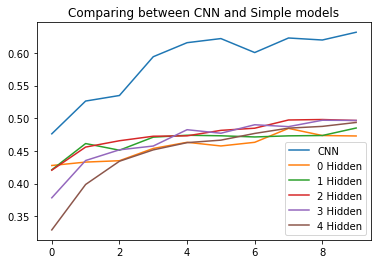

In [20]:
plt.plot(all_acc_1)
plt.plot(all_acc_2)
plt.plot(all_acc_3)
plt.plot(all_acc_4)
plt.plot(all_acc_5)
plt.plot(all_acc_6)
plt.legend(['CNN','0 Hidden','1 Hidden','2 Hidden','3 Hidden','4 Hidden'])
plt.title('Comparing between CNN and Simple models')
plt.show()

Explaination:
In the above plot, we can see that the accuracy of CNN model is much better than each dense neural network with 0-4 hidden layer. At the same time, we can find that there is no significant difference in the accuracy of those simple dense neural network models, no matter the number of hidden layer is 0 to 4. 

I think the reason of this result is CNN model have more complicate structure, it preserves more spatial features in the data. So the result is much better.

# Question (b)

Replace Fluid units by Sigmoid units

In [11]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


net_7 = Net()
net_7 = net_7.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_7.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 10
all_acc_7 = []
for epoch in range(n_epochs):  
    net_7.to('cuda')
    net_7.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize
        outputs = net_7(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
            
    net_7.eval()
    net_7.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_7(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_7.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

D:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy of the network in 1th epoch on the 10000 test images: 10 %
Accuracy of the network in 2th epoch on the 10000 test images: 10 %
Accuracy of the network in 3th epoch on the 10000 test images: 10 %
Accuracy of the network in 4th epoch on the 10000 test images: 10 %
Accuracy of the network in 5th epoch on the 10000 test images: 10 %
Accuracy of the network in 6th epoch on the 10000 test images: 10 %
Accuracy of the network in 7th epoch on the 10000 test images: 10 %
Accuracy of the network in 8th epoch on the 10000 test images: 19 %
Accuracy of the network in 9th epoch on the 10000 test images: 20 %
Accuracy of the network in 10th epoch on the 10000 test images: 21 %
Finished Training


## Result of Question (b)

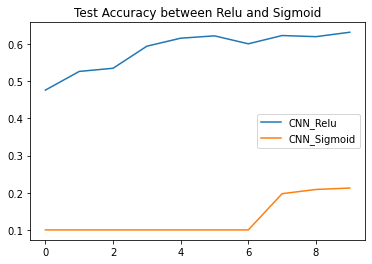

In [12]:
plt.plot(all_acc_1)
plt.plot(all_acc_7)
plt.legend(['CNN_Relu','CNN_Sigmoid'])
plt.title('Test Accuracy between Relu and Sigmoid')
plt.show()

Explaination:
The accuracy of Model using Relu units is much higher than the Model using Sigmoid units.

This may because Relu function can avoid the problem of gradient vanishing. And Model by using ReLu units converges faster to the final result.



# Question (c)

Original CNN Model without dropout and without Data Augmentation

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_11 = Net()
net_11 = net_11.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_11.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_11 = []
train_acc_11 = []
for epoch in range(n_epochs):  
    net_11.to('cuda')
    net_11.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize & training accuracy
        outputs = net_11(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_11.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_11.eval()
    net_11.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_11(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_11.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.37452
Accuracy of the network in 1th epoch on the 10000 test images: 46 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.52238
Accuracy of the network in 2th epoch on the 10000 test images: 55 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.57786
Accuracy of the network in 3th epoch on the 10000 test images: 59 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.61464
Accuracy of the network in 4th epoch on the 10000 test images: 59 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.63766
Accuracy of the network in 5th epoch on the 10000 test images: 60 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.65956
Accuracy of the network in 6th epoch on the 10000 test images: 61 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.67356
Accuracy of the network in 7th epoch on the 10000 test images: 61 %
Accuracy of the netw

Original CNN Model with dropout and without Data Augmentation

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_8 = Net()
net_8 = net_8.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_8.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_8 = []
train_acc_2 = []
for epoch in range(n_epochs):  
    net_8.to('cuda')
    net_8.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize & training accuracy
        outputs = net_8(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_2.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_8.eval()
    net_8.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_8(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_8.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.29018
Accuracy of the network in 1th epoch on the 10000 test images: 41 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.41320
Accuracy of the network in 2th epoch on the 10000 test images: 50 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.44942
Accuracy of the network in 3th epoch on the 10000 test images: 49 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.47372
Accuracy of the network in 4th epoch on the 10000 test images: 55 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.48704
Accuracy of the network in 5th epoch on the 10000 test images: 54 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.49588
Accuracy of the network in 6th epoch on the 10000 test images: 55 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.50606
Accuracy of the network in 7th epoch on the 10000 test images: 56 %
Accuracy of the netw

### Data Augmentation

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Original CNN Model without dropout and with Data Augmentation

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_9 = Net()
net_9 = net_9.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_9.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_9 = []
train_acc_3 = []
for epoch in range(n_epochs):  
    net_9.to('cuda')
    net_9.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize & training accuracy
        outputs = net_9(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_3.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_9.eval()
    net_9.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_9(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_9.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.27370
Accuracy of the network in 1th epoch on the 10000 test images: 37 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.40704
Accuracy of the network in 2th epoch on the 10000 test images: 44 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.45910
Accuracy of the network in 3th epoch on the 10000 test images: 46 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.48332
Accuracy of the network in 4th epoch on the 10000 test images: 48 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.51008
Accuracy of the network in 5th epoch on the 10000 test images: 49 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.52128
Accuracy of the network in 6th epoch on the 10000 test images: 52 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.53784
Accuracy of the network in 7th epoch on the 10000 test images: 52 %
Accuracy of the netw

Original CNN Model with dropout and with Data Augmentation

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net_10 = Net()
net_10 = net_10.to ('cuda')

# Define a Loss function and optimizer
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_10.parameters(), lr=0.001, momentum=0.9)

# epoch
n_epochs = 20
all_acc_10 = []
train_acc_4 = []
for epoch in range(n_epochs): 
    net_10.to('cuda')
    net_10.train()
    running_loss = 0.0
    train_accs=[]
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs=inputs.to('cuda')
        labels=labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward & backward & optimize & training accuracy
        outputs = net_10(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accs = (outputs.argmax(dim=-1) == labels.to('cuda')).float().mean()
        train_accs.append(accs)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_4.append(train_acc.cpu().item())
    print(f"Accuracy of the network in {epoch + 1}th epoch on the 50000 train images: {train_acc:.5f}")
            
    net_10.eval()
    net_10.cpu()
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
        # calculate outputs by running images through the network
            outputs = net_10(images)
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    all_acc_10.append(acc)
    print(f'Accuracy of the network in {epoch + 1}th epoch on the 10000 test images: {100 * correct // total} %')
print('Finished Training')

Accuracy of the network in 1th epoch on the 50000 train images: 0.21296
Accuracy of the network in 1th epoch on the 10000 test images: 31 %
Accuracy of the network in 2th epoch on the 50000 train images: 0.30470
Accuracy of the network in 2th epoch on the 10000 test images: 36 %
Accuracy of the network in 3th epoch on the 50000 train images: 0.33418
Accuracy of the network in 3th epoch on the 10000 test images: 36 %
Accuracy of the network in 4th epoch on the 50000 train images: 0.35086
Accuracy of the network in 4th epoch on the 10000 test images: 39 %
Accuracy of the network in 5th epoch on the 50000 train images: 0.36254
Accuracy of the network in 5th epoch on the 10000 test images: 41 %
Accuracy of the network in 6th epoch on the 50000 train images: 0.37056
Accuracy of the network in 6th epoch on the 10000 test images: 40 %
Accuracy of the network in 7th epoch on the 50000 train images: 0.37112
Accuracy of the network in 7th epoch on the 10000 test images: 41 %
Accuracy of the netw

## Result of Question (c)

Plot of Training Accuracy

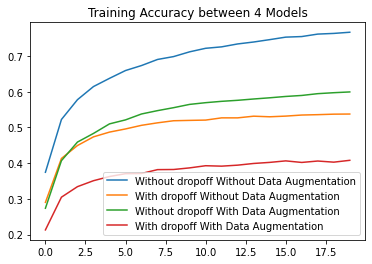

In [18]:
plt.plot(train_acc_11)
plt.plot(train_acc_2)
plt.plot(train_acc_3)
plt.plot(train_acc_4)
plt.legend(['Without dropoff Without Data Augmentation','With dropoff Without Data Augmentation','Without dropoff With Data Augmentation','With dropoff With Data Augmentation'])
plt.title('Training Accuracy between 4 Models')
plt.show()

Plot of Test Accuracy

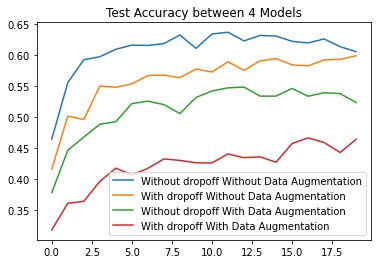

In [19]:
plt.plot(all_acc_11)
plt.plot(all_acc_8)
plt.plot(all_acc_9)
plt.plot(all_acc_10)
plt.legend(['Without dropoff Without Data Augmentation','With dropoff Without Data Augmentation','Without dropoff With Data Augmentation','With dropoff With Data Augmentation'])
plt.title('Test Accuracy between 4 Models')
plt.show()

Explaination: Both dropoff and data augmentation can lead to a lower accuracy in both training datas and test datas in this case. 

We can see that Model without dropoff and without data augmentation has the highest accuracy in both training datas and test datas. And with dropoff and data augmentation gets the lowest.


In my opinion, the reason why dropoff leads to a bad result is the sample CNN model is not deeper, the number of layer is too small, so it doesn't need the dropoff process to get better results.

And as for Data Augmentation, the lower accuracy maybe because the way to augmentation is not good enough or baybe because the number of epoch is too small. I choose the AutoAugmentation as the way to augmentation, it may lose some features of the dataset in the process of augmentation. And, if the number of epochs is higher (e.g. 100), the results may be better.